# Clustering

# Índice 
1. [Introduction](#introduction)
2. [Import Materials](#importmaterials)    
    2.1. [Import Libraries](#importlibraries)     
    2.2. [Import the dataset](#importdataset)
3. [Clusterings](#clustering)    
    3.1. [Hierarchical Clustering](#hierarchical)   
    3.2. [K Means](#kmeans)     
    3.3. [SOM](#som)   
    3.4. [Mean Shift Clustering](#mean)    
    3.5. [DBSCAN](#dbscan)         
    3.6. [Gaussian Mixure Model](#gmm)  

<hr>
<a class="anchor" id="introduction">
    
# 1. Introduction
    
</a>


This notebook analyzes customer data from ABCDEats Inc., a fictional food delivery service, over three months. The goal is to create clusters of customers and make different marketing startegies for each of them....    
**Project by** Dinis Pinto (20240612), Joana Rodrigues (20240603), João Marques (20240656), and Mara Simões (20240326) - **Group 27**.

<hr>
<a class="anchor" id="importmaterials">
    
# 2. Import Materials
    
</a>

<hr>
<a class="anchor" id="importlibraries">
    
## 2.1. Import Libraries
    
</a>

For this project, we'll install some helpful libraries to make analysis easier and add features like better plotting, data handling, and modeling tools. For example, `matplotlib` and `seaborn` allow us to create clear, customizable plots, while `pandas` and `numpy` make data processing smoother.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import KNNImputer
from minisom import MiniSom
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import pickle
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from matplotlib.patches import RegularPolygon
import matplotlib.colors as mpl_colors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colorbar import Colorbar
from sklearn.cluster import estimate_bandwidth, MeanShift
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram

<hr>
<a class="anchor" id="importdataset">
    
## 2.2. Import Dataset
    
</a>

### Data in dataset
The different columns in the dataset give out the following information:   
- `customer_id` - Unique identifier for each customer.
- `customer_region` - Geographic region where the customer is located.
- `customer_age` - Age of the customer.
- `vendor_count` - Number of unique vendors the customer has ordered from.
- `product_count` - Total number of products the customer has ordered.
- `is_chain` - Indicates whether the customer’s order was from a chain restaurant.
- `first_order` - Number of days from the start of the dataset when the customer first placed an order.
- `last_order` - Number of days from the start of the dataset when the customer most recently placed an order.
- `last_promo` - The category of the promotion or discount most recently used by the customer.
- `payment_method` - Method most recently used by the customer to pay for their orders.
- `CUI_American`, `CUI_Asian`, `CUI_Chinese`, `CUI_Italian`... - The amount in monetary units spent by the customer from the indicated type of cuisine. 
- `DOW_0` to `DOW_6` - Number of orders placed on each day of the week (0 = Sunday, 6 = Saturday).
- `HR_0` to `HR_23` - Number of orders placed during each hour of the day (0 = midnight, 23 = 11 PM).

In [8]:
df_preferences = pickle.load(open("df_preferences.pkl", 'rb'))

<hr>
<a class="anchor" id="clustering">
    
# 3. Clustering Algorithms
    
</a>

<a class="anchor" id="hierarchical">

## 3.1. Hierarchical Clustering
</a>

Hierarchical clustering is used to group similar data points into clusters based on similarity. It forms a hierarchical structure known as a dendrogram where we can visualize how clusters are combined or separated at each step. 

We start by define the best linkage method and plot the dendogram to choose the optimal number of clusters. To help decide the optimal number of clusters, we compared the mean values of the variables and used the silhouette score.

### Function for plotting R2 for various hierarchical methods

In [9]:
def get_ss(df): # Calculation of total sum squared
    ss = np.sum(df.var() * (df.count() - 1))
    return ss 

# ------------------------------------------------------------------
def get_ssb(df, label_col):  # sum of squares between groups (SSB)
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.drop(columns=[label_col])  # Drop the label column to include all other features
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))) )
    ssb = np.sum(ssb_i)
    return ssb

# ------------------------------------------------------------------
def get_ssw(df, feats, label_col): # sum of squares within groups (SSW)
    feats_label = feats+[label_col]
    df_k = df[feats_label].groupby(by=label_col).apply(lambda col: get_ss(col), include_groups=False)
    return df_k.sum()

# ------------------------------------------------------------------
def get_r2(df, feats, label_col): #  R-squared value (measures the proportion of variance explained by the grouping or clustering).
    sst = get_ss(df)                 
    ssw = get_ssw(df, feats, label_col)     
    ssb = sst - ssw              
    return (ssb/sst)

# ------------------------------------------------------------------
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"): # R² for different numbers of clusters using hierarchical clustering
    
    r2 = []  
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus+1):  
        cluster = AgglomerativeClustering(n_clusters=i, metric=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df) 
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)  
        r2.append(get_r2(df_concat, feats, 'labels'))
        
    return np.array(r2)

In [10]:
from sklearn.metrics import silhouette_score

def silhouette(df, labels):
    return silhouette_score(df, labels, metric='euclidean')

In [11]:
def get_r2_kmeans(df, max_nclus, min_nclus=1, random_state=42):    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        kmeans = KMeans(n_clusters=i, random_state=random_state)
        
        # get cluster labels
        labels = kmeans.fit_predict(df)
        
        # concat df with labels
        df_concat = pd.concat([df, pd.Series(labels, name='labels', index=df.index)], axis=1)
        
        # append the R2 of the given cluster solution
        r2.append(get_r2(df_concat, feats, 'labels'))
        
    return np.array(r2)

### Defining the best linkage method and the best partitioning method (based on the R2)

In [12]:
# Visualizing the R² scores for each hierarchical method

hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 5

r2_hc = np.vstack([get_r2_hc(df_preferences, link, max_nclus=max_nclus, min_nclus=1, dist="euclidean") for link in hc_methods])

r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()

fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)

plt.show()

KeyboardInterrupt: 

#### With best hierarchical linkage (Ward), plot the dendogram and chose the optimal number of clusters to use

In [7]:
linkage = 'ward'
distance = 'euclidean'

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hc_labels = hclust.fit_predict(df_preferences)
hc_labels

array([22175, 27743, 25023, ...,     1,     2,     0], dtype=int64)

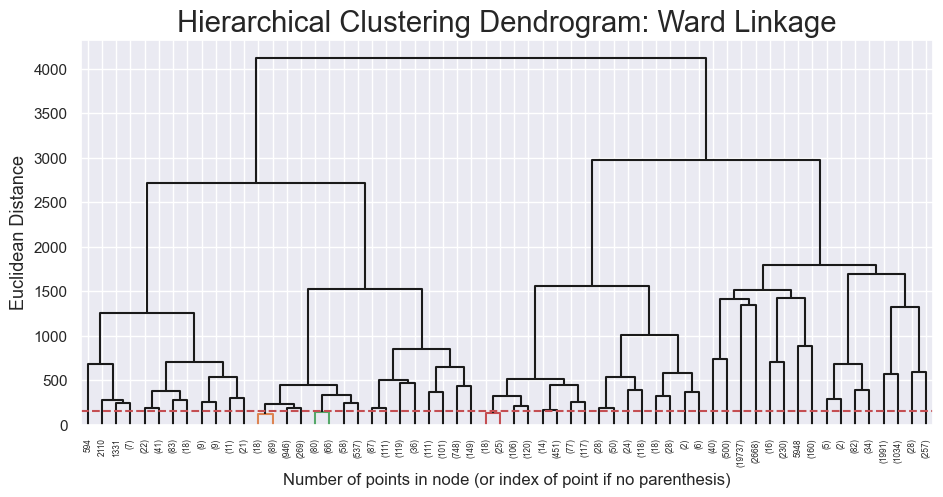

In [8]:
# create the counts of samples under each node (number of points being merged)

from scipy.cluster.hierarchy import dendrogram

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 149
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

#### Create a hierarchical clustering algorithm and compare the mean values of the variables

In [9]:
# n_clusters = 3

hc3_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=3)
hc3_labels = hc3_clust.fit_predict(df_preferences)

df_concat = pd.concat([df_preferences, pd.Series(hc3_labels, name='hierarc_labels', index=df_preferences.index)], axis=1)
df_concat.groupby('hierarc_labels').mean()

CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  \
hierarc_labels                                                     
0                   5.357349  54.558389       2.431395  0.164356   
1                   4.838638   3.582444       2.238469  0.927542   
2                   4.787188  13.943611       3.448652  0.057246   

                CUI_Chicken Dishes  CUI_Chinese  CUI_Desserts  CUI_Healthy  \
hierarc_labels                                                               
0                         0.109197     1.215812      1.540061     0.723697   
1                         0.897850     1.446242      0.757785     1.009079   
2                         0.028918     1.333844      1.771614     0.464859   

                CUI_Indian  CUI_Italian  CUI_Japanese  CUI_Noodle Dishes  \
hierarc_labels                                                             
0                 0.597490     1.215807      3.034206           0.099875   
1                 1.854486     3.653838      2.976576           0.825855   
2                 0.084692     0.549734      3.587013           0.000932   

                CUI_OTHER  CUI_Street Food / Snacks  CUI_Thai  
hierarc_labels                                                 
0                1.036404                  4.511246  0.334665  
1                3.409474                  1.231602  0.949213  
2                0.285923                 62.171589  0.042471

In [10]:
# n_clusters = 4

hc4_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=4)
hc4_labels = hc4_clust.fit_predict(df_preferences)

df_concat = pd.concat([df_preferences, pd.Series(hc4_labels, name='hierarc_labels', index=df_preferences.index)], axis=1)
df_concat.groupby('hierarc_labels').mean()

CUI_American   CUI_Asian  CUI_Beverages  CUI_Cafe  \
hierarc_labels                                                      
0                   4.838638    3.582444       2.238469  0.927542   
1                   4.751016   46.762210       2.219790  0.155844   
2                   4.787188   13.943611       3.448652  0.057246   
3                  14.898973  177.243795       5.761339  0.298304   

                CUI_Chicken Dishes  CUI_Chinese  CUI_Desserts  CUI_Healthy  \
hierarc_labels                                                               
0                         0.897850     1.446242      0.757785     1.009079   
1                         0.113523     1.044403      1.385770     0.604973   
2                         0.028918     1.333844      1.771614     0.464859   
3                         0.041116     3.913214      3.968080     2.592009   

                CUI_Indian  CUI_Italian  CUI_Japanese  CUI_Noodle Dishes  \
hierarc_labels                                                             
0                 1.854486     3.653838      2.976576           0.825855   
1                 0.581614     1.272618      2.605634           0.105589   
2                 0.084692     0.549734      3.587013           0.000932   
3                 0.847321     0.321786      9.778482           0.009955   

                CUI_OTHER  CUI_Street Food / Snacks  CUI_Thai  
hierarc_labels                                                 
0                3.409474                  1.231602  0.949213  
1                1.011061                  3.621770  0.338902  
2                0.285923                 62.171589  0.042471  
3                1.435223                 18.508571  0.267991

In [11]:
# n_clusters = 5

hc5_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
hc5_labels = hc5_clust.fit_predict(df_preferences)

df_concat = pd.concat([df_preferences, pd.Series(hc5_labels, name='hierarc_labels', index=df_preferences.index)], axis=1)
df_concat.groupby('hierarc_labels').mean()

CUI_American   CUI_Asian  CUI_Beverages  CUI_Cafe  \
hierarc_labels                                                      
0                  24.438197    2.808989       0.987393  0.984031   
1                   4.751016   46.762210       2.219790  0.155844   
2                   4.787188   13.943611       3.448652  0.057246   
3                  14.898973  177.243795       5.761339  0.298304   
4                   1.957288    3.696150       2.422391  0.919237   

                CUI_Chicken Dishes  CUI_Chinese  CUI_Desserts  CUI_Healthy  \
hierarc_labels                                                               
0                         0.295007     0.368946      0.192598     0.489167   
1                         0.113523     1.044403      1.385770     0.604973   
2                         0.028918     1.333844      1.771614     0.464859   
3                         0.041116     3.913214      3.968080     2.592009   
4                         0.986474     1.604616      0.840873     1.085511   

                CUI_Indian  CUI_Italian  CUI_Japanese  CUI_Noodle Dishes  \
hierarc_labels                                                             
0                 0.936376     7.460326      1.409531           0.177183   
1                 0.581614     1.272618      2.605634           0.105589   
2                 0.084692     0.549734      3.587013           0.000932   
3                 0.847321     0.321786      9.778482           0.009955   
4                 1.989458     3.094242      3.206949           0.921217   

                CUI_OTHER  CUI_Street Food / Snacks  CUI_Thai  
hierarc_labels                                                 
0                2.831273                  0.613804  0.932499  
1                1.011061                  3.621770  0.338902  
2                0.285923                 62.171589  0.042471  
3                1.435223                 18.508571  0.267991  
4                3.494476                  1.322425  0.951670

#### Silhouette Score

The silhouette score define how-well separated the clusters are, indicating with a higher score the better clusters.

In [12]:
from sklearn.metrics import silhouette_score

# Compute silhouette score for different n_clusters
for n_clusters in [3, 4, 5]:
    hc_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=n_clusters)
    labels = hc_clust.fit_predict(df_preferences)
    silhouette_avg = silhouette_score(df_preferences, labels)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")

Silhouette Score for 3 clusters: 0.43666452521048404
Silhouette Score for 4 clusters: 0.3905884835408031
Silhouette Score for 5 clusters: 0.23651009934257872


#### Final Hierarchical clustering solution

<a class="anchor" id="kmeans">

## 3.2. K-Means Algorithm
</a>

#### 1. Defining the number of clusters - Inertia

Measure the inertia: sum of squared distances between the data points and the centroids - Sum of Squares within the cluster

In [13]:
range_clusters = range(1, 11)    # test between 1 and 10 clusters
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_preferences)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

The inertia plot: Plot the results of testing different values of K for K-means

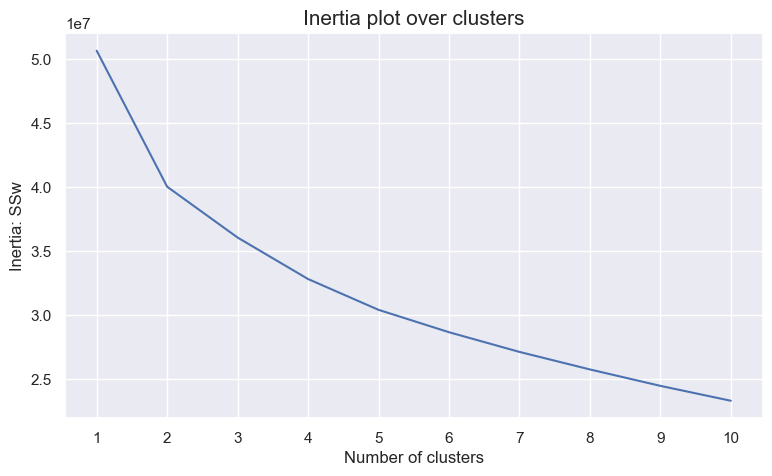

In [14]:
fig, ax = plt.subplots(figsize=(9,5))

ax.plot(range_clusters, inertia)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)

plt.show()

In [15]:
n_initializations = 5  # number of different random initializations to try
max_nclus = 10

r2_kmeans = np.vstack([get_r2_kmeans(df_preferences, 
                                    max_nclus=max_nclus, 
                                    min_nclus=1, 
                                    random_state=seed) 
                                    for seed in range(n_initializations)])

In [16]:
# Create DataFrame with all initializations
r2_kmeans_df = pd.DataFrame(
   r2_kmeans.T,
   index=range(1, max_nclus + 1),
   columns=[f'init_{i}' for i in range(n_initializations)]
)

# Add mean and std columns
r2_kmeans_df['mean_R2'] = r2_kmeans_df.mean(axis=1)
r2_kmeans_df['std_R2'] = r2_kmeans_df.std(axis=1)

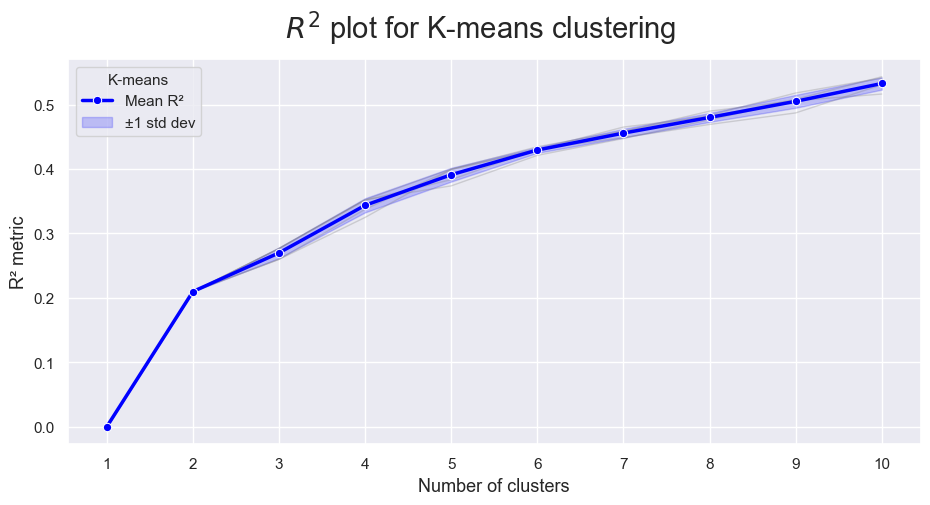

In [17]:
sns.set()

# Plot data
fig = plt.figure(figsize=(11,5))

# Plot individual initializations with lower alpha for less visual clutter
for i in range(n_initializations):
    plt.plot(r2_kmeans_df.index, r2_kmeans_df[f'init_{i}'], 
             alpha=0.3, color='gray', linestyle='-', linewidth=1)

# Plot mean with confidence band
sns.lineplot(data=r2_kmeans_df['mean_R2'], linewidth=2.5, marker='o', 
             label='Mean R²', color='blue')

# Add confidence band
plt.fill_between(r2_kmeans_df.index,
                 r2_kmeans_df['mean_R2'] - r2_kmeans_df['std_R2'],
                 r2_kmeans_df['mean_R2'] + r2_kmeans_df['std_R2'],
                 alpha=0.2, color='blue', label='±1 std dev')

# Finalize the plot
plt.legend(title="K-means", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)

fig.suptitle("$R^2$ plot for K-means clustering", fontsize=21)

plt.show()

The elbow seems to exist with 2 or 4 clusters introduced.

Silhouette Coefficient

Measure how well represented each datapoint is by its cluster. Measure of how similar an object is to its own cluster compared to other clusters. The goal is to make sure to assign each datapoint to the correct cluster.

For n_clusters = 2, the average silhouette_score is : 0.5963136187626602
For n_clusters = 3, the average silhouette_score is : 0.5626013302305539
For n_clusters = 4, the average silhouette_score is : 0.39213683098478513
For n_clusters = 5, the average silhouette_score is : 0.4013917189790461
For n_clusters = 6, the average silhouette_score is : 0.39658634438978096
For n_clusters = 7, the average silhouette_score is : 0.2945081340170223
For n_clusters = 8, the average silhouette_score is : 0.30383756046826726
For n_clusters = 9, the average silhouette_score is : 0.32368773500858367
For n_clusters = 10, the average silhouette_score is : 0.3281186557305868


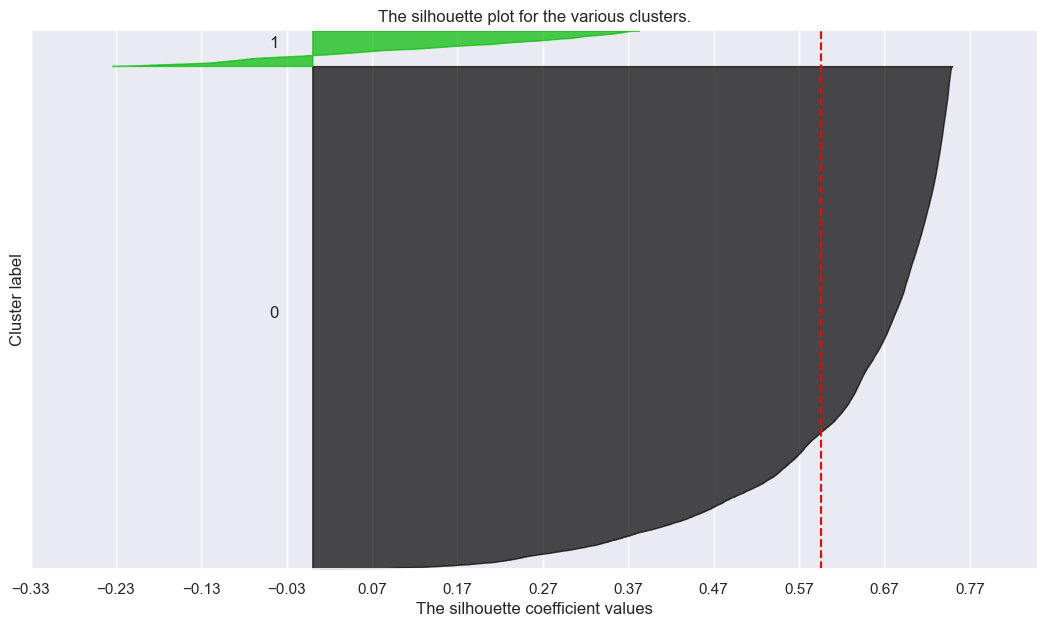

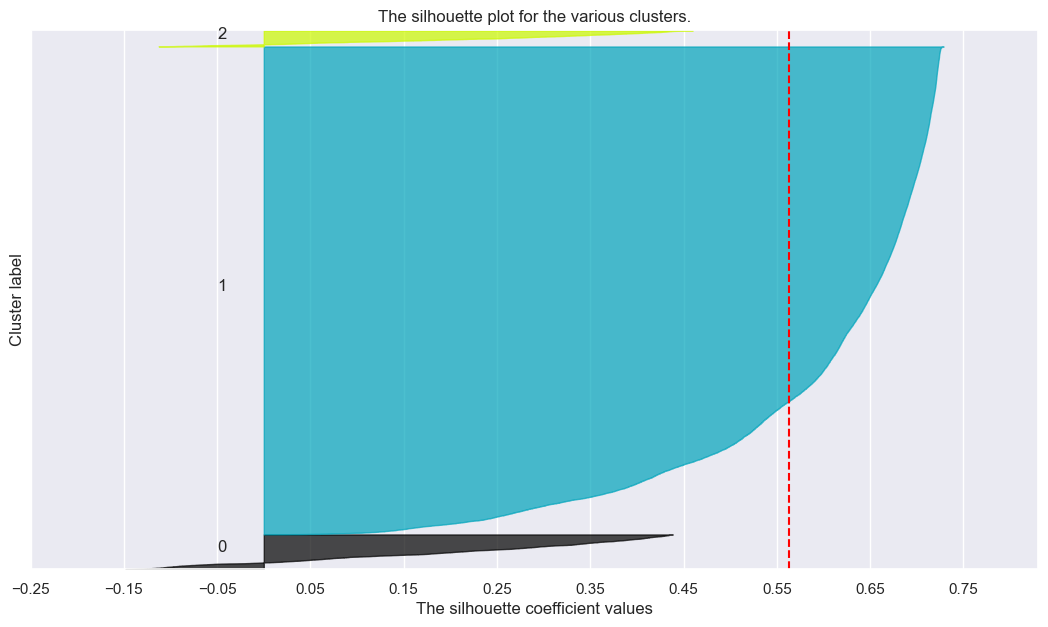

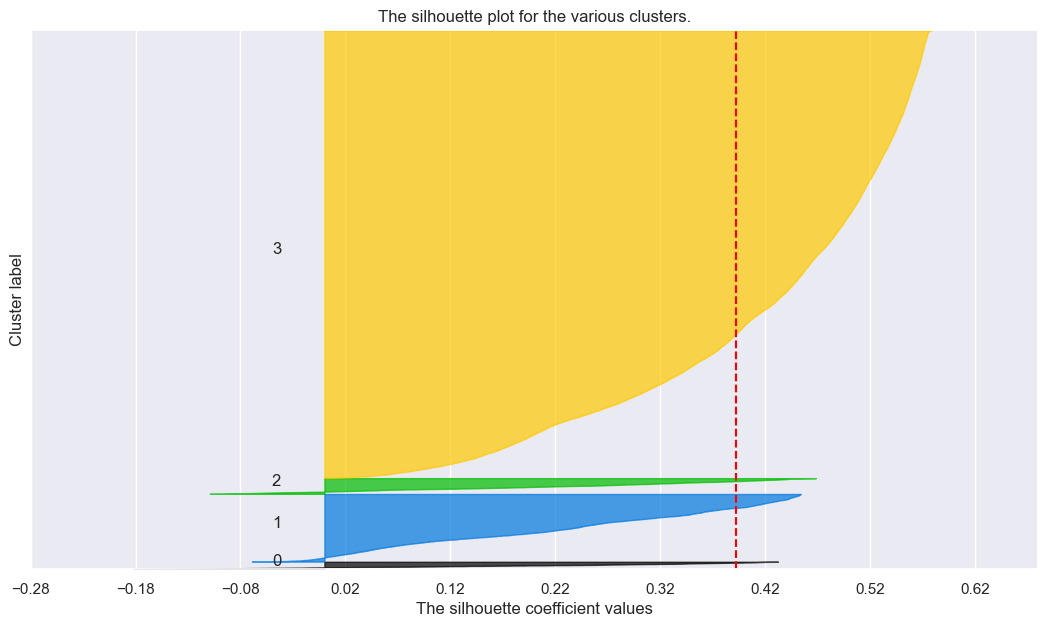

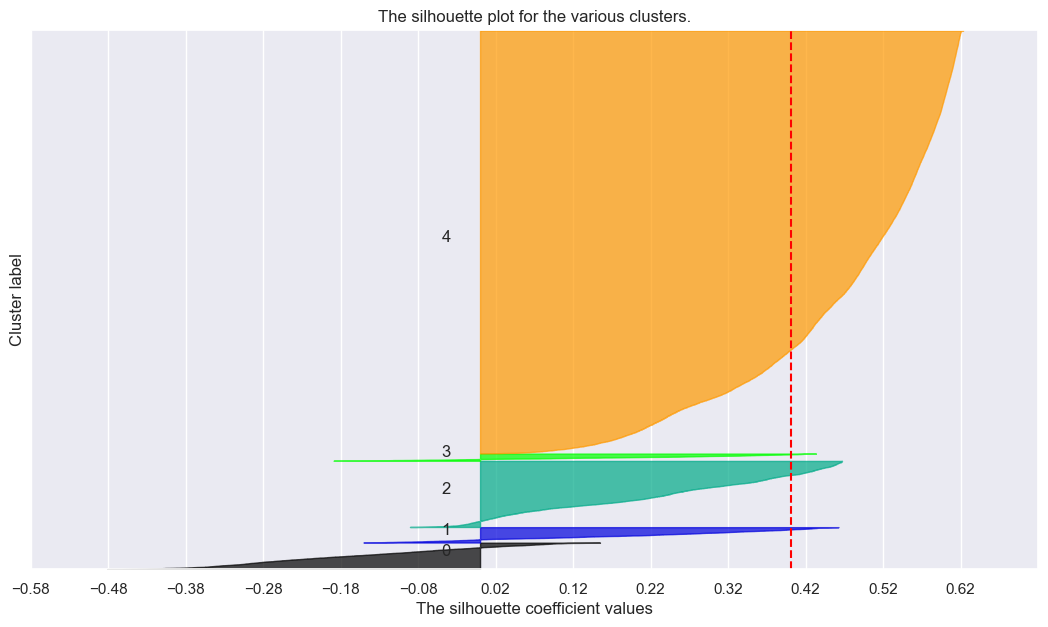

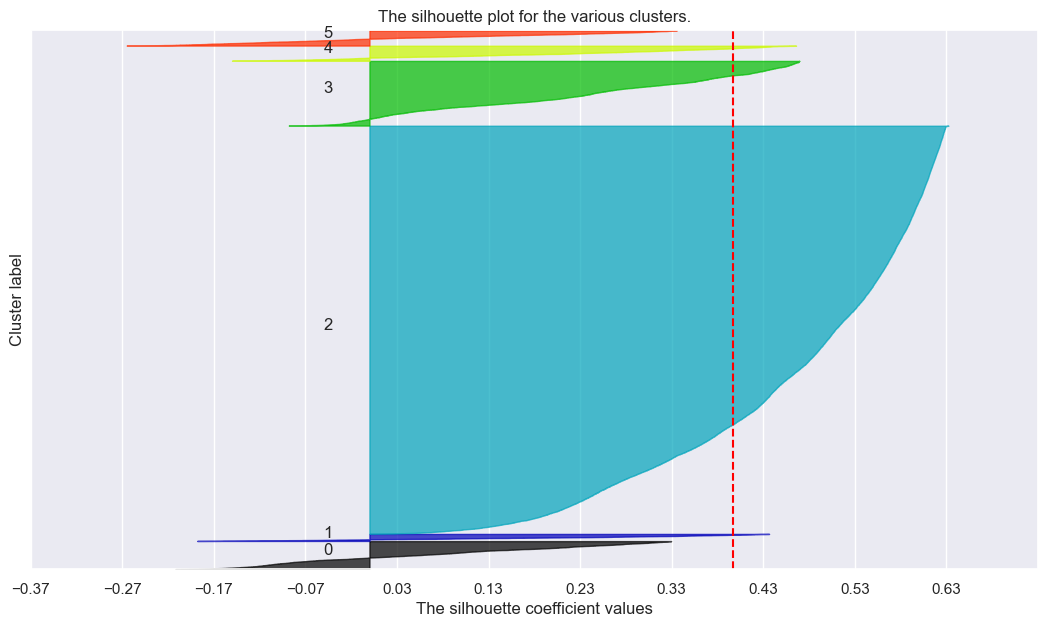

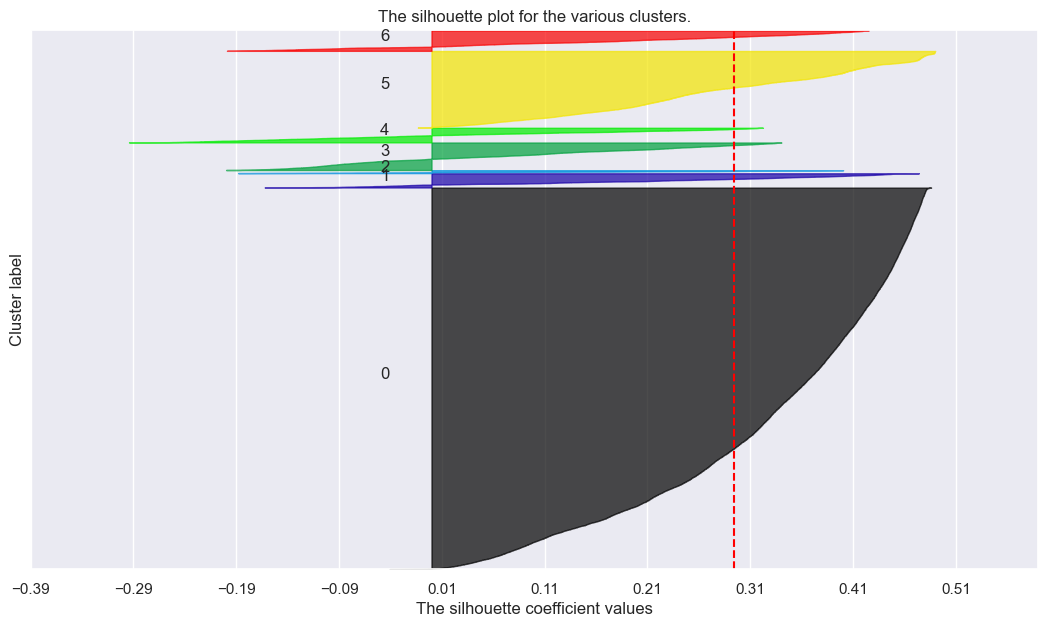

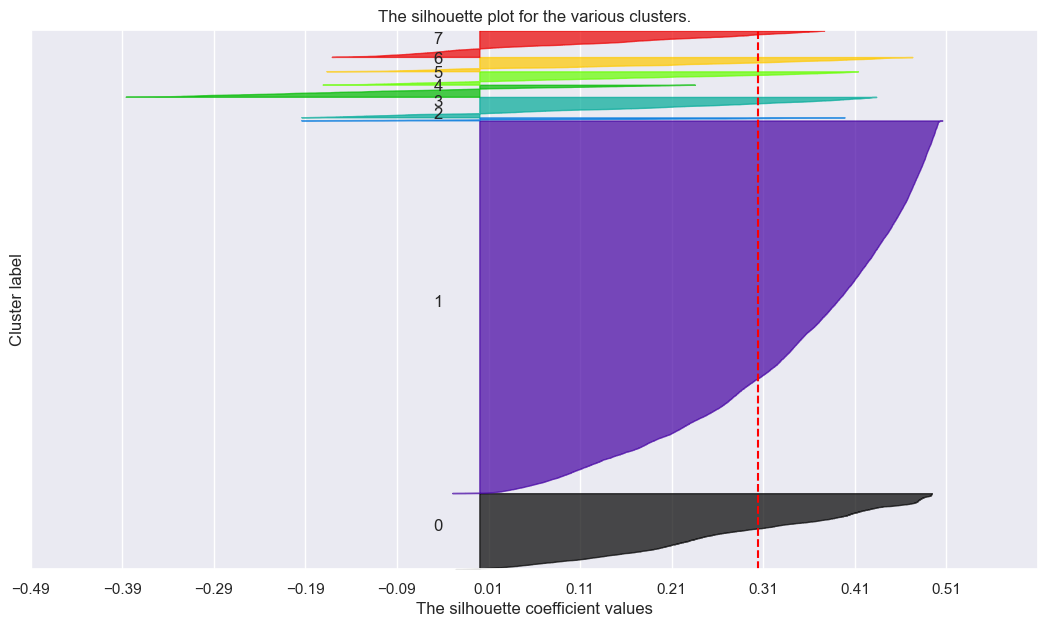

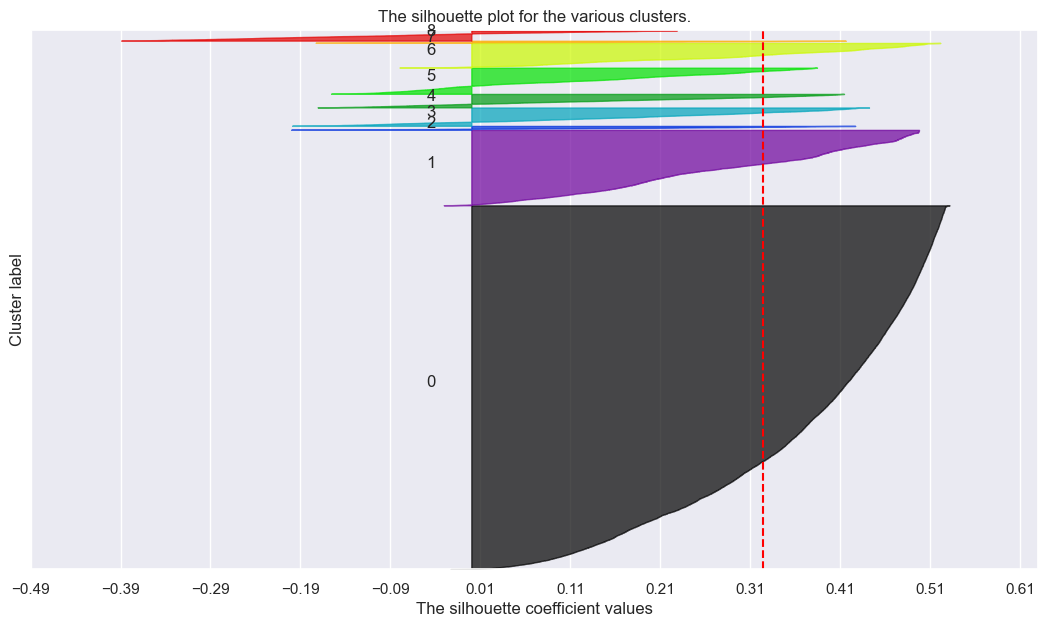

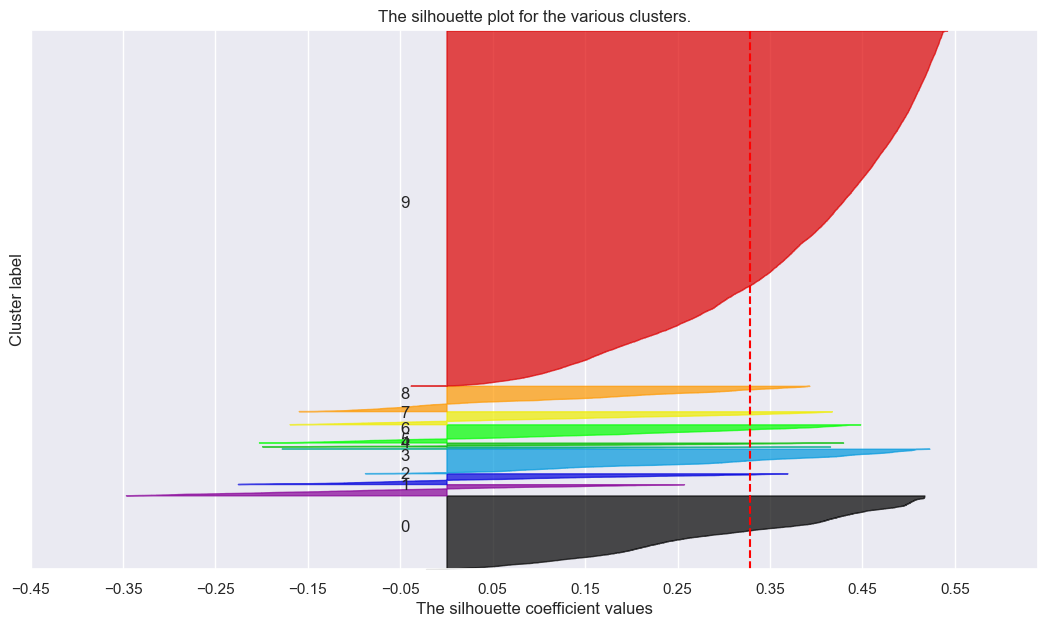

In [18]:
# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_preferences)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_preferences, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_preferences, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_preferences) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

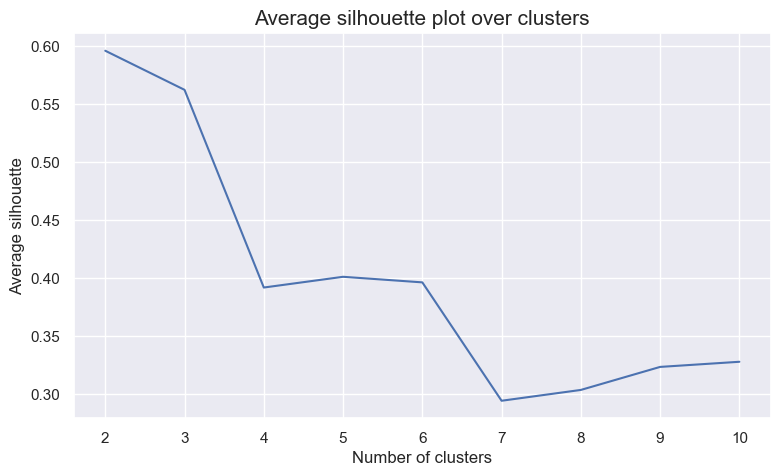

In [19]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))


#  Why range_clusters[1:] ? 
# Remember we skipped k=1 in the cell above

plt.plot(range_clusters[1:], ## Plot X-axis; 
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

### Final K-Means Clustering Solution

In [20]:
number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_preferences)
km_labels

array([3, 3, 3, ..., 3, 3, 3])

In [21]:
df_concat = pd.concat((df_preferences, pd.Series(km_labels, name='labels', index=df_preferences.index)), axis=1)
df_concat.groupby('labels').mean()


CUI_American   CUI_Asian  CUI_Beverages  CUI_Cafe  CUI_Chicken Dishes  \
labels                                                                          
0          12.816389  144.500856       7.514282  0.866505            0.032593   
1           5.568671   41.510073       3.171670  0.848254            0.221916   
2           6.202097   16.787200       3.721503  0.049946            0.036670   
3           4.621321    2.796385       2.041678  0.823229            0.892705   

        CUI_Chinese  CUI_Desserts  CUI_Healthy  CUI_Indian  CUI_Italian  \
labels                                                                    
0          3.228843      4.015926     2.039282    1.073449     1.001111   
1          1.237211      1.611254     1.059486    0.963730     1.312568   
2          1.080335      3.519395     0.879805    0.095968     0.620270   
3          1.423614      0.636028     0.923807    1.804309     3.669576   

        CUI_Japanese  CUI_Noodle Dishes  CUI_OTHER  CUI_Street Food / Snacks  \
labels                                                                         
0           8.296644           0.005162   1.493333                 19.023171   
1           4.212992           0.153863   1.650910                  3.052348   
2           4.075200           0.008562   0.339384                 71.643384   
3           2.700194           0.828754   3.334749                  1.438827   

        CUI_Thai  
labels            
0       0.246713  
1       0.525362  
2       0.030195  
3       0.928359

<a class="anchor" id="som">

## 3.3. SOM
</a>

In [13]:
data_som = df_preferences.copy()

In [14]:
data_som

CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  CUI_Chicken Dishes  \
0              0.00       0.00           0.00       0.0                 0.0   
1             12.82       6.39           0.00       0.0                 0.0   
2              9.20       0.00           0.00       0.0                 0.0   
3              0.00      13.70           0.00       0.0                 0.0   
4             14.57      40.87           0.00       0.0                 0.0   
...             ...        ...            ...       ...                 ...   
31883          0.00       0.00          18.04       0.0                 0.0   
31884         18.04       0.00           0.00       0.0                 0.0   
31885          0.00       0.00           0.00       0.0                 0.0   
31886          0.00      12.03           0.00       0.0                 0.0   
31887          0.00       0.00           0.00       0.0                 0.0   

       CUI_Chinese  CUI_Desserts  CUI_Healthy  CUI_Indian  CUI_Italian  \
0              0.0          0.00          0.0       28.88         0.00   
1              0.0          0.00          0.0        0.00         0.00   
2              0.0          0.00          0.0        0.00         0.00   
3              0.0          0.00          0.0       17.86         0.00   
4              0.0          0.00          0.0        0.00         0.00   
...            ...           ...          ...         ...          ...   
31883          0.0          0.00          0.0        0.00         0.00   
31884          0.0          0.00          0.0        0.00         0.00   
31885          0.0         17.79          0.0        0.00         0.00   
31886          0.0          0.00          0.0        0.00         0.00   
31887          0.0          0.00          0.0        0.00         7.91   

       CUI_Japanese  CUI_Noodle Dishes  CUI_OTHER  CUI_Street Food / Snacks  \
0               0.0                0.0        0.0                       0.0   
1               0.0                0.0        0.0                       0.0   
2               0.0                0.0        0.0                       0.0   
3               0.0                0.0        0.0                       0.0   
4               0.0                0.0        0.0                       0.0   
...             ...                ...        ...                       ...   
31883           0.0                0.0        0.0                       0.0   
31884           0.0                0.0        0.0                       0.0   
31885           0.0                0.0        0.0                       0.0   
31886           0.0                0.0        0.0                       0.0   
31887           0.0                0.0        0.0                       0.0   

       CUI_Thai  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
...         ...  
31883       0.0  
31884       0.0  
31885       0.0  
31886       0.0  
31887       0.0  

[31736 rows x 15 columns]

In [15]:
num_data_points = data_som.shape[0]
print("Nr. of data points:" , num_data_points)

print("Mapsize:" , 5*(num_data_points)**(1/2)) # from an university study

Nr. of data points: 31736
Mapsize: 890.730037665734


In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Add get_neighbors for hexagonal topology
def get_neighbors_hexagonal(som, node):
    """Get hexagonal neighbors of a node."""
    x, y = node
    neighbors = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1)]:
        nx, ny = x + dx, y + dy
        if 0 <= nx < som._weights.shape[0] and 0 <= ny < som._weights.shape[1]:
            neighbors.append((nx, ny))
    return neighbors

MiniSom.get_neighbors = get_neighbors_hexagonal  # Add to MiniSom

# Function to calculate topographic error
def calculate_topographic_error(som, data):
    """Calculate topographic error for SOM."""
    errors = 0
    for sample in data:
        bmu_1 = som.winner(sample)  # Best Matching Unit (BMU 1)
        distances = np.linalg.norm(som._weights - sample, axis=-1)  # Distances to all nodes
        bmu_2 = np.unravel_index(np.argsort(distances.ravel())[1], distances.shape)  # BMU 2
        neighbors = som.get_neighbors(bmu_1)
        if bmu_2 not in neighbors:
            errors += 1
    return errors / len(data)


def evaluate_scaling_methods(data, scaling_methods, M=20, N=20, iterations=500):
    results = []
    for method_name, scaler in scaling_methods.items():
        # Scale the data
        scaled_data = scaler.fit_transform(data)
        
        # Initialize and train SOM
        som = MiniSom(M, N, scaled_data.shape[1], sigma=5.0, learning_rate=0.5, random_seed=42)
        som.random_weights_init(scaled_data)
        som.train(scaled_data, iterations)
        
        # Compute errors
        qe = som.quantization_error(scaled_data)
        te = calculate_topographic_error(som, scaled_data)
        
        # Append results
        results.append({
            "Scaling Method": method_name,
            "QE": qe,
            "TE": te
        })
    
    return pd.DataFrame(results)

# Define scaling methods
scaling_methods = {
    "Min-Max Scaling": MinMaxScaler(),
    "Standardization": StandardScaler(),
    "Robust Scaling": RobustScaler()
}

# Evaluate
results = evaluate_scaling_methods(df_preferences.values, scaling_methods)
print(results)


    Scaling Method        QE        TE
0  Min-Max Scaling  0.037099  0.125189
1  Standardization  1.494497  0.127899
2   Robust Scaling  9.470647  0.117249


Best scaler for us is MinMax Scaler

In [17]:
scaler = MinMaxScaler()
df_preferences_scaled = scaler.fit_transform(df_preferences)

#### Finding the best choice of parameters and training the SOM

In [18]:
import itertools

def grid_search_som(data, param_grid):
    results = []
    for params in itertools.product(*param_grid.values()):
        grid_size, sigma, learning_rate, iterations = params
        som = MiniSom(
            x=grid_size[0], y=grid_size[1],
            input_len=data.shape[1],
            sigma=sigma, learning_rate=learning_rate,
            random_seed=42, neighborhood_function='gaussian'
        )
        som.random_weights_init(data)
        som.train(data, iterations)

        qe = som.quantization_error(data)
        te = calculate_topographic_error(som, data)

        results.append({
            'Grid Size': grid_size,
            'Sigma': sigma,
            'Learning Rate': learning_rate,
            'Iterations': iterations,
            'Quantization Error': qe,
            'Topographic Error': te
        })

    return pd.DataFrame(results)

def get_neighbors_hexagonal(som, node):
    x, y = node
    neighbors = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1)]:
        nx, ny = x + dx, y + dy
        if 0 <= nx < som._weights.shape[0] and 0 <= ny < som._weights.shape[1]:
            neighbors.append((nx, ny))
    return neighbors

MiniSom.get_neighbors = get_neighbors_hexagonal

In [19]:
param_grid = {
    'grid_size': [(30, 30)],
    'sigma': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
    'learning_rate': [0.1, 0.5, 1.0, 1.5, 2.0],
    'iterations': [500, 1000]
}

In [20]:
results_df = grid_search_som(df_preferences_scaled, param_grid)

c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\minisom.py:631: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


KeyboardInterrupt: 

In [278]:
results_df['Combined Score'] = results_df['Quantization Error'] + results_df['Topographic Error']
best_row_idx = results_df['Combined Score'].idxmin()
best_params = results_df.loc[best_row_idx]
print("Best Parameters:")
print(best_params)

Best Parameters:
Grid Size             (30, 30)
Sigma                      3.0
Learning Rate              1.0
Iterations                1000
Quantization Error    0.026619
Topographic Error     0.201317
Combined Score        0.227936
Name: 55, dtype: object


In [21]:
results_df.sort_values(by='Combined Score', ascending=True).head()

NameError: name 'results_df' is not defined

#### Training the SOM on the best Parameters

In [22]:
from minisom import MiniSom
import numpy as np

best_grid_size = (30, 30)
best_sigma = 3.0
best_learning_rate = 1.0
best_iterations = 1000

som = MiniSom(
    x=best_grid_size[0], 
    y=best_grid_size[1], 
    input_len=df_preferences_scaled.shape[1],
    sigma=best_sigma, 
    learning_rate=best_learning_rate,
    neighborhood_function='gaussian',
    random_seed=42
)

# Optionally: PCA-based weight initialization
som.pca_weights_init(df_preferences_scaled)

# Or random initialization
# som.random_weights_init(df_preferences_scaled)
print("PCA weights init")
print("Before training:")
qe_before = np.round(som.quantization_error(df_preferences_scaled), 5)
te_before = np.round(calculate_topographic_error(som, df_preferences_scaled), 5)
print(f"QE: {qe_before}, TE: {te_before}")

# Train the SOM
som.train(df_preferences_scaled, best_iterations)

print("After training:")
qe_after = np.round(som.quantization_error(df_preferences_scaled), 5)
te_after = np.round(calculate_topographic_error(som, df_preferences_scaled), 5)
print(f"QE: {qe_after}, TE: {te_after}")


# som = MiniSom(
#     x=best_grid_size[0], 
#     y=best_grid_size[1], 
#     input_len=df_preferences_scaled.shape[1],
#     sigma=best_sigma, 
#     learning_rate=best_learning_rate,
#     neighborhood_function='gaussian',
#     random_seed=42
# )

# # Or random initialization
# som.random_weights_init(df_preferences_scaled)

# print("Random weights init")
# print("Before training:")
# qe_before = np.round(som.quantization_error(df_preferences_scaled), 5)
# te_before = np.round(calculate_topographic_error(som, df_preferences_scaled), 5)
# print(f"QE: {qe_before}, TE: {te_before}")

# # Train the SOM
# som.train(df_preferences_scaled, best_iterations)

# print("After training:")
# qe_after = np.round(som.quantization_error(df_preferences_scaled), 5)
# te_after = np.round(calculate_topographic_error(som, df_preferences_scaled), 5)
# print(f"QE: {qe_after}, TE: {te_after}")


c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


PCA weights init
Before training:
QE: 0.07143, TE: 1.0
After training:
QE: 0.02695, TE: 0.18818


QE and TE with random weights initialization was worse than with the PCA weights initialization

In [23]:
def convert_map_to_euclidean(i, j):
    x = i + 0.5 * (j % 2)  # Shift every other row by 0.5
    y = j * (np.sqrt(3) / 2)
    return x, y

def plot_hexagons(
    ax, 
    colornorm, 
    matrix_vals, 
    label="", 
    annot=False, 
    cmap=None
):
    """
    Plots the values in 'matrix_vals' using hexagonal cells.
    
    Parameters:
    -----------
    ax : matplotlib Axes
        The axes on which to draw the hexagons.
    colornorm : matplotlib.colors.Normalize
        Normalization object for mapping values to [0, 1].
    matrix_vals : 2D array
        Values to be visualized. shape = (M, N).
    label : str, optional
        Title label for the subplot.
    annot : bool, optional
        If True, numeric values are shown inside each hex.
    cmap : matplotlib.colors.Colormap or None, optional
        Colormap to use. Defaults to 'inferno' if None is provided.
    """
    # Default to 'inferno' if no cmap is specified
    if cmap is None:
        cmap = cm.inferno

    rows, cols = matrix_vals.shape
    for i in range(rows):
        for j in range(cols):
            x, y = convert_map_to_euclidean(i, j)
            value = matrix_vals[i, j]
            # Map the value to a color using the given colormap + normalization
            hex_color = cmap(colornorm(value))
            
            # Draw a regular hexagon
            hex_patch = RegularPolygon(
                (x, y),
                numVertices=6,
                radius=np.sqrt(1 / 3),
                facecolor=hex_color,
                alpha=1,
                edgecolor="white",
                linewidth=0.5
            )
            ax.add_patch(hex_patch)

            # Optionally annotate
            if annot:
                annot_val = int(np.round(value))
                ax.text(
                    x, y, annot_val,
                    ha="center",
                    va="center",
                    fontsize="x-small",
                )

    # Formatting
    ax.margins(0.05)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_title(label)

    # Add color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    sm = cm.ScalarMappable(norm=colornorm, cmap=cmap)
    sm.set_array([])
    Colorbar(ax=cax, mappable=sm, orientation="vertical")


### Ploting the Plane Components using the trained SOM

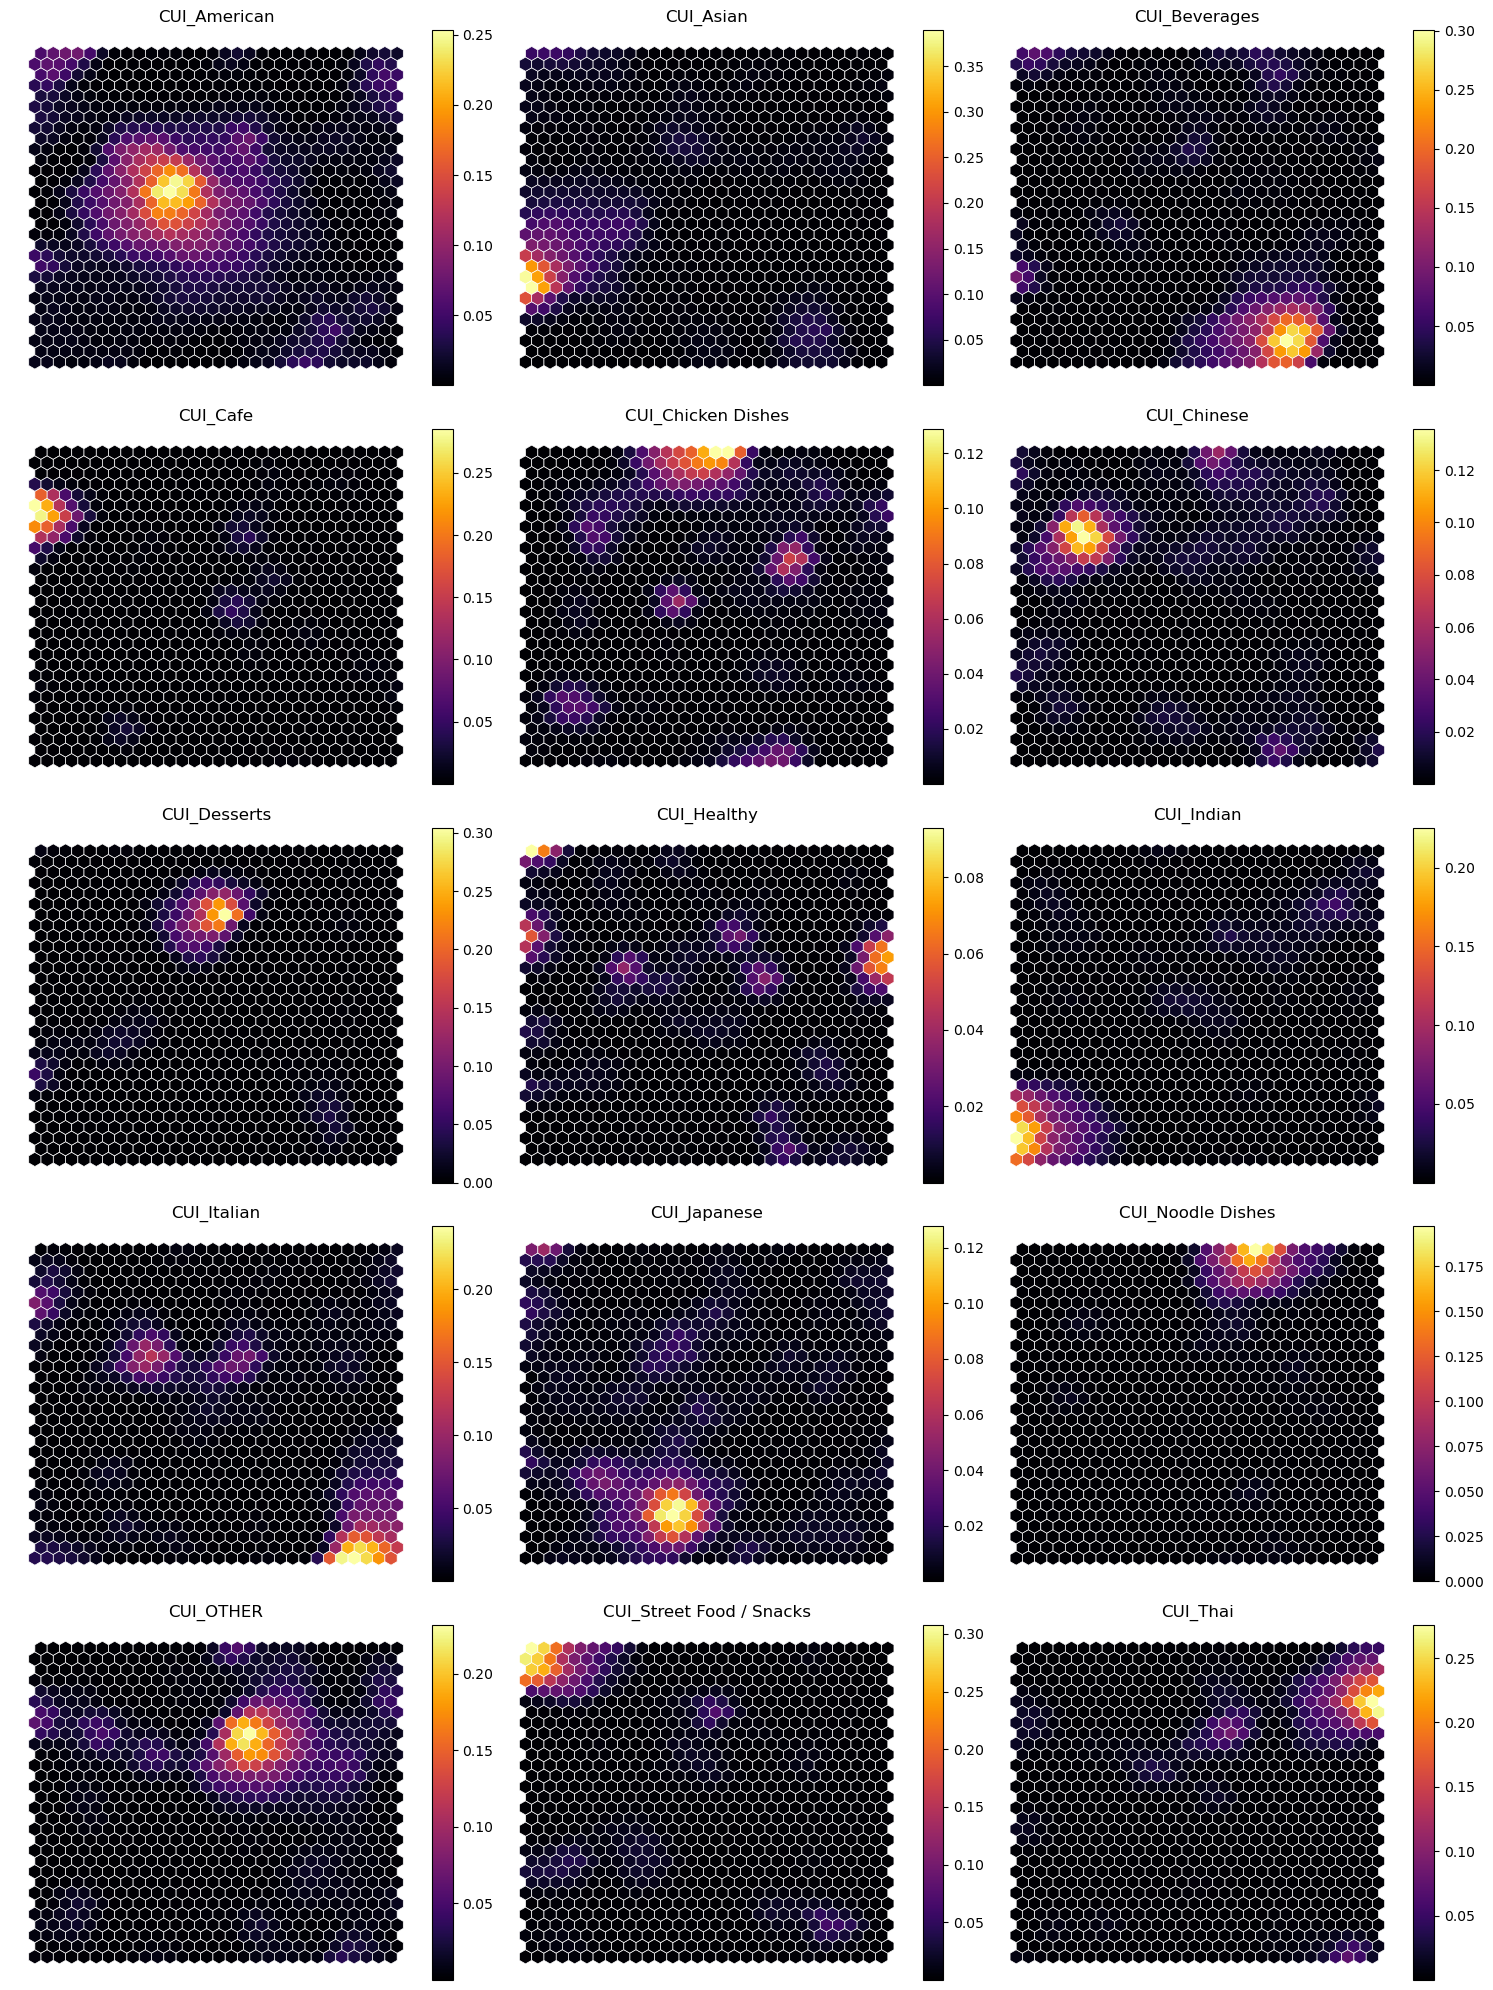

In [24]:
from matplotlib.colors import Normalize

weights = som.get_weights()  # shape (M, N, num_features)
num_features = weights.shape[2]
feature_names = df_preferences.columns  # Use the names of features from your dataset

# Define 5 rows and 3 columns for 15 subplots
rows, cols = 5, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 20))  # Adjust figsize for better visualization
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot the feature planes
for i in range(min(num_features, rows * cols)):
    plane = weights[:, :, i]  # MxN array for feature i
    ax = axes[i]

    colornorm = Normalize(vmin=plane.min(), vmax=plane.max())
    
    plot_hexagons(
        ax=ax, 
        colornorm=colornorm, 
        matrix_vals=plane, 
        label=feature_names[i],  # Use the feature name as the label
        annot=False
    )

# If there are fewer features than subplots, hide unused subplots
for j in range(min(num_features, rows * cols), rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

##### General Observations
1. Clustered Spending Behavior:

- High-intensity regions (yellow/orange hexagons) represent higher money spent on specific cuisines.
- These regions are well-separated for some cuisines (e.g., American, Beverages), indicating distinct customer groups with specific preferences.

Overlap Across Cuisines:
- Some cuisines, such as Healthy and Chicken Dishes, show dispersed high-intensity regions, suggesting that spending on these cuisines overlaps across multiple customer groups.
- Niche Preferences: Certain cuisines, like CUI_Indian, have isolated high-intensity clusters in specific regions, indicating niche spending behavior by distinct customer segments.

#### Ploting the U-Matrix using the trained SOM

In [67]:
# Suppose you have a trained SOM named 'som'
u_matrix = som.distance_map()  # shape (M, N)

In [68]:
M, N = som.get_weights().shape[:2]  # e.g., 10, 10
final_weights = som.get_weights().reshape(M*N, -1)  
# shape = (M*N, num_features)

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(final_weights)
# 'labels' is a 1D array of length M*N, cluster ID of each neuron


c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [69]:
from collections import defaultdict

cluster_coords = defaultdict(list)

for i in range(M):
    for j in range(N):
        # neuron index in flattened array
        neuron_index = i*N + j
        
        cluster_id = labels[neuron_index]
        
        # convert (i, j) to Euclidean coords
        x, y = convert_map_to_euclidean(i, j)
        
        # save
        cluster_coords[cluster_id].append((x, y))


### U-Matrix using trained SOM

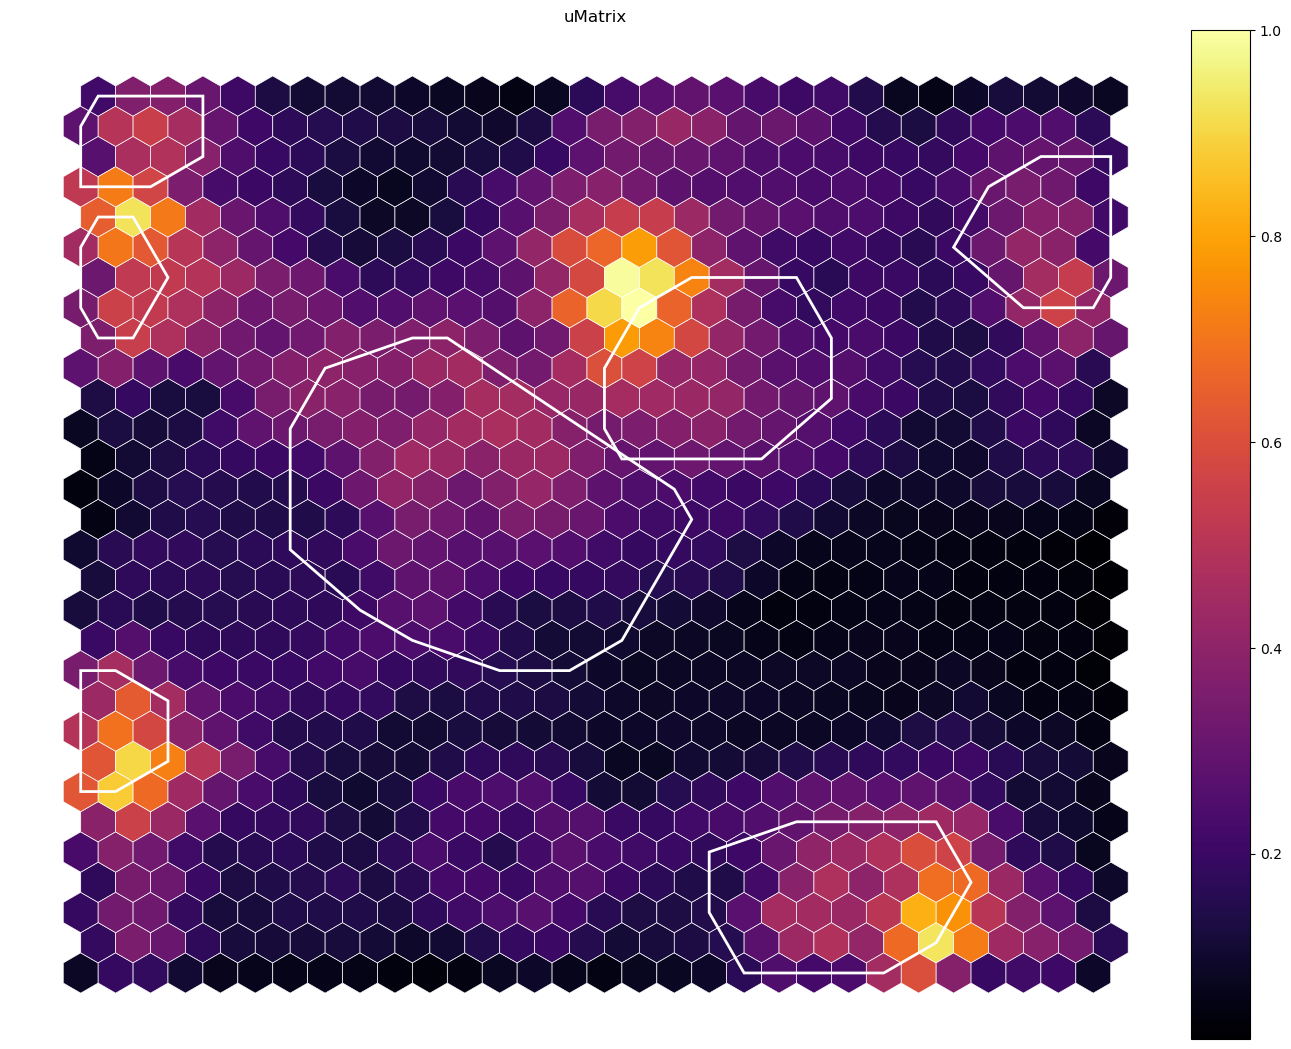

In [70]:
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPoint
from matplotlib.patches import Polygon

fig, ax = plt.subplots(figsize=(16, 16))

# 1) Plot the UMatrix as usual
colornorm = Normalize(vmin=u_matrix.min(), vmax=u_matrix.max())
plot_hexagons(ax, colornorm, u_matrix, label="uMatrix", annot=False)

# 2) Draw convex hulls around each cluster
for cluster_id, coords in cluster_coords.items():
    if not coords:
        continue
    if cluster_id == 0: continue
    if cluster_id == 5: continue
    if cluster_id == 8: continue

    # If there's only 1-2 neurons, you won't get a polygon; handle that gracefully:
    if len(coords) < 3:
        # Optionally, just plot a small circle or skip
        x_c, y_c = np.mean([x for x, _ in coords]), np.mean([y for _, y in coords])
        circ = plt.Circle((x_c, y_c), radius=0.3, fill=False, color='red', linewidth=2)
        ax.add_patch(circ)
        continue

    # Build a shapely MultiPoint for the cluster
    points = MultiPoint([Point(x, y) for (x, y) in coords])
    hull = points.convex_hull  # returns a Polygon (or possibly a LineString if all points are collinear)
    
    # Get the polygon exterior coordinates
    if hull.geom_type == 'Polygon':
        hull_x, hull_y = hull.exterior.xy
        hull_coords = np.vstack((hull_x, hull_y)).T  # shape (n_points, 2)
        
        # Create a Matplotlib Polygon
        poly = Polygon(
            hull_coords,
            fill=False,
            edgecolor='white',
            linewidth=2
        )
        ax.add_patch(poly)
    elif hull.geom_type == 'LineString':
        # If it's just a line, plot that line:
        lx, ly = hull.xy
        ax.plot(lx, ly, color='red', linewidth=2)
    # else: could handle other edge cases if needed

plt.show()


##### Key Clusters in the U-Matrix
1. Top-Left Region:
Two small but distinct clusters are separated by high-distance boundaries.
These likely correspond to customer groups spending predominantly on Cafe and Street Food/Snacks and Chinese.

2. Center-Top Region:
A high-intensity cluster surrounded by strong boundaries.
This cluster could represent customers spending significantly on Chicken Dishes and Noodle Dishes, as observed in the component planes.

3. Bottom-Left Region:
A moderately cohesive cluster with clear separations from other clusters.
Could represent spending on Asian cuisine based on previous insights.

4. Bottom-Right Region:
A compact and highly distinct cluster, surrounded by strong boundaries.
Likely corresponds to cuisines such as Beverages or Italian, where spending was localized in their component planes.

### Hits Map


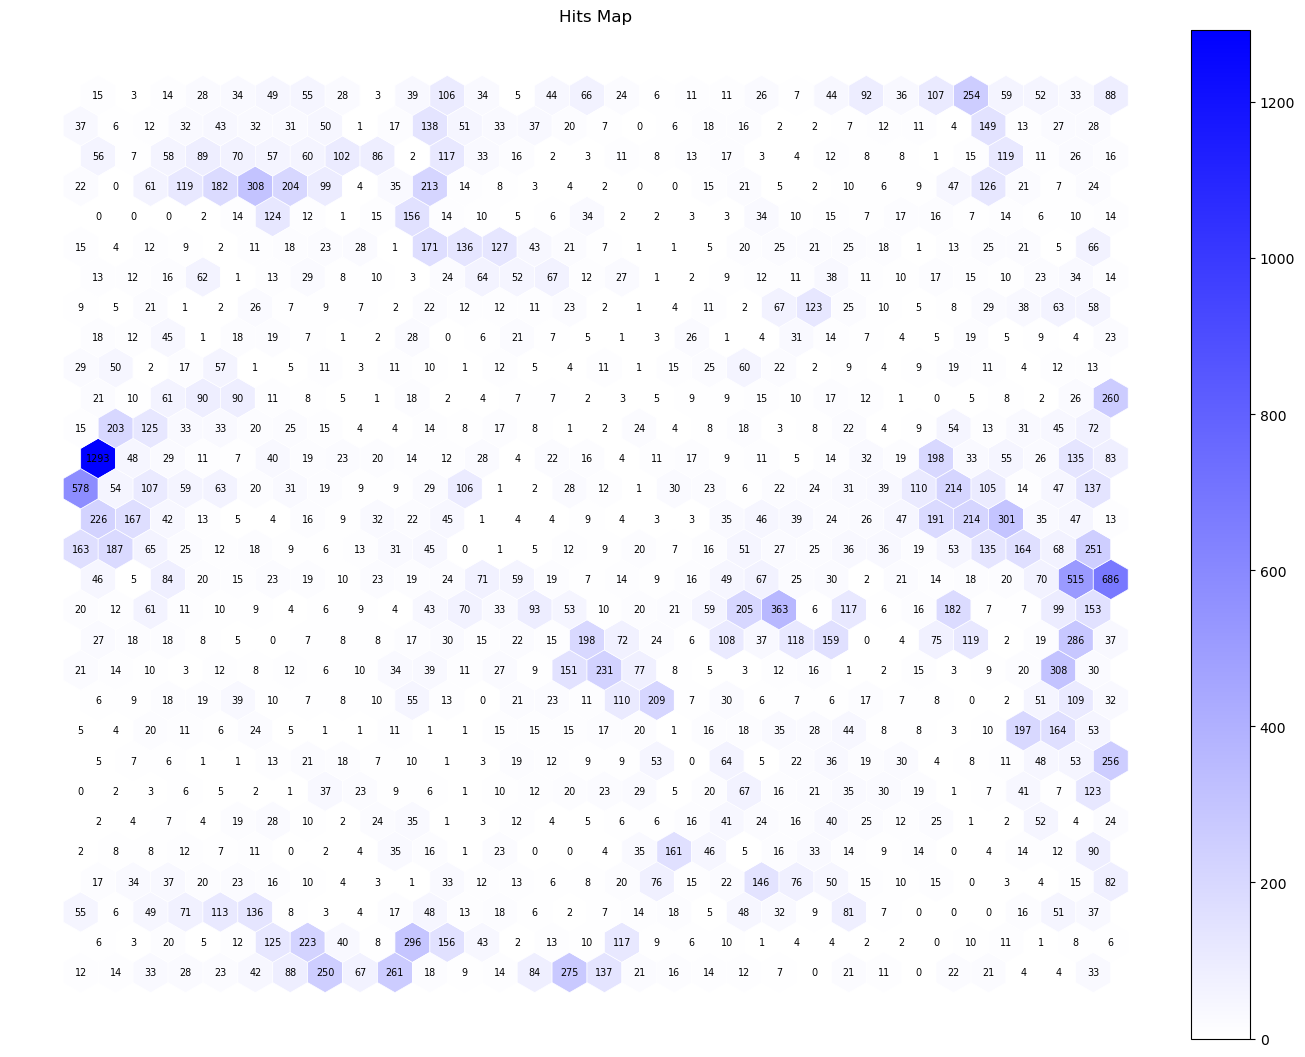

In [73]:
from matplotlib.colors import Normalize, LinearSegmentedColormap

def plot_hits_map_hex(som, data, title="Hits Map"):
    """
    1) Compute the hits map for 'data' given a trained 'som'.
    2) Plot it in hex form with a white→blue colormap.
    """
    # A) Compute hits per neuron
    M, N = som.get_weights().shape[:2]
    hits_map = np.zeros((M, N))
    
    # For each sample, find BMU and increment counter
    for sample in data:
        i, j = som.winner(sample)
        hits_map[i, j] += 1
    
    # B) Create a custom white→blue colormap
    white2blue = LinearSegmentedColormap.from_list(
        'white2blue', ['white', 'blue'], N=256
    )
    
    # C) Normalize from 0 up to the max number of hits
    colornorm = Normalize(vmin=0, vmax=hits_map.max())
    
    # D) Plot with the hex function
    fig, ax = plt.subplots(figsize=(16, 16))
    plot_hexagons(
        ax=ax,
        colornorm=colornorm,
        matrix_vals=hits_map,
        label=title,
        annot=True,            # Show numeric hit counts
        cmap=white2blue        # Use our custom white→blue colormap
    )
    plt.show()

plot_hits_map_hex(som, df_preferences_scaled)

1. High-Density Regions
- Top-Left Region:
The neuron with the highest value (1293 hits) is located in the top-left corner.
This indicates a very dense cluster of data points in this area, where customers share highly similar spending patterns across the analyzed cuisines.

- Center-Right Region:
Another high-density neuron (686 and 515 hits) is observed in the bottom-right.
This indicates a second significant group of customers with distinct but internally consistent spending behaviors.

- Mid-Center to Bottom-Center Region:
Other moderately dense neurons are scattered across this area, forming smaller clusters that represent diverse customer segments.

2. 2. Low-Density and Sparse Regions
- Center to Right-Center:
The middle of the map contains mostly low-hit neurons. This suggests that fewer data points are mapped here, likely because these neurons represent outliers or less common patterns in spending behavior.

- Upper-Center Region:
Similarly sparse, indicating a lack of significant clustering or groups with shared patterns in this part of the SOM.


### Clustering the neuron weight vectors

#### Flatten the SOM Weights


In [30]:
weights_3d = som.get_weights()         # shape: (M, N, num_features)
M, N, num_features = weights_3d.shape

weights_2d = weights_3d.reshape(M * N, num_features)
# shape: (M*N, num_features)

#### Apply K-Means Clustering to the Flattened Weights

c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

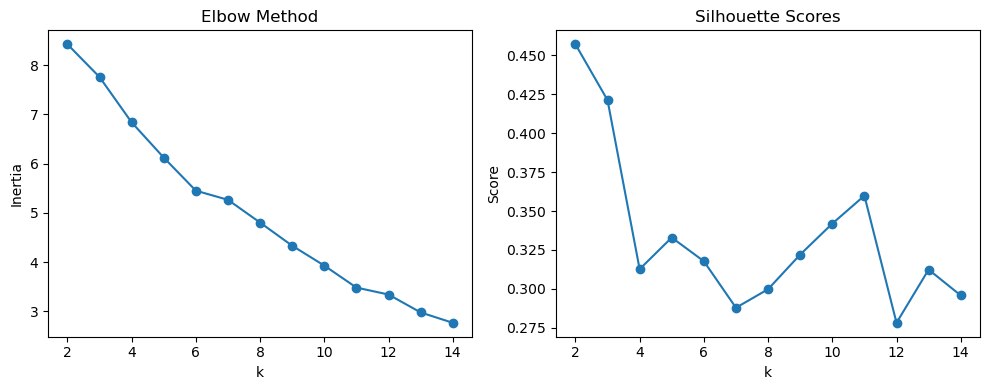

In [31]:
inertias = []
sil_scores = []
K_values = range(2, 15)  # Try k from 2 to 14

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(weights_2d)
    
    # Inertia
    inertias.append(kmeans.inertia_)
    
    # Silhouette (requires more than 1 cluster)
    sil = silhouette_score(weights_2d, labels)
    sil_scores.append(sil)

# Plot elbow
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_values, inertias, 'o-')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

# Plot silhouette
plt.subplot(1,2,2)
plt.plot(K_values, sil_scores, 'o-')
plt.title("Silhouette Scores")
plt.xlabel("k")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


### Visualizing the K-Means Clusters on the SOM

Using 8 clusters, we can change this number then

In [109]:
weights_3d = som.get_weights()  # shape (M, N, num_features)
M, N, num_features = weights_3d.shape
weights_2d = weights_3d.reshape(M*N, num_features)

k = 6  # or whatever you choose
kmeans_preferences = KMeans(n_clusters=k, random_state=42)
nodeclus_labels_preferences = kmeans_preferences.fit_predict(weights_2d)
# labels is a 1D array of length M*N, cluster ID for each neuron

cluster_map = labels.reshape(M, N)

c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


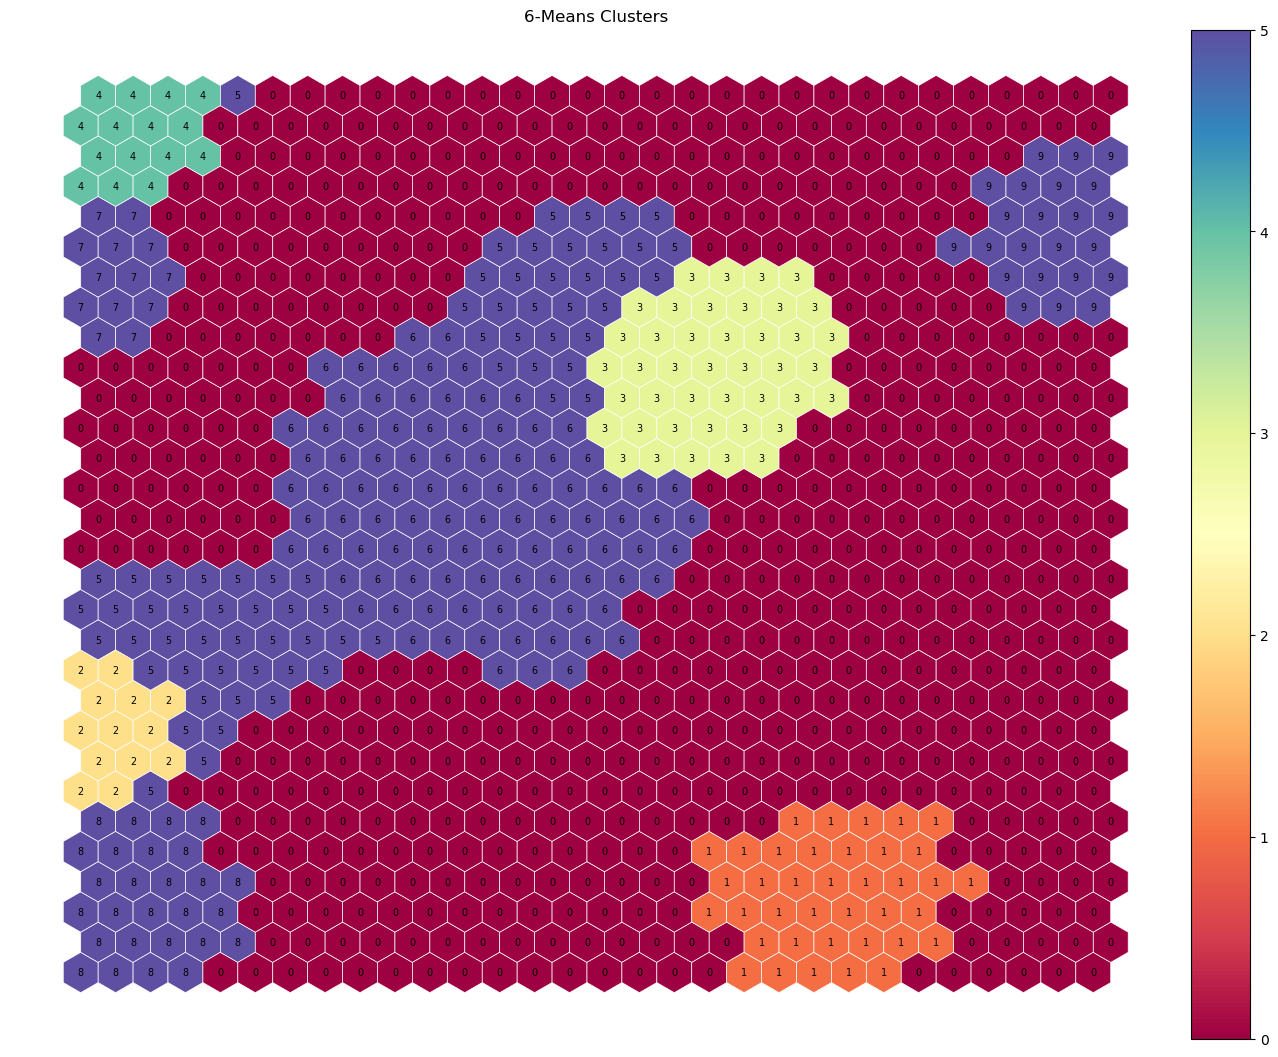

In [110]:
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(16, 16))

# Create a discrete colormap for 'k' clusters:

norm = colors.Normalize(vmin=0, vmax=k-1)

plot_hexagons(
    ax=ax,
    colornorm=norm,
    matrix_vals=cluster_map,
    label=f"{k}-Means Clusters",
    annot=True,
    cmap=cm.Spectral
)

plt.show()


##### Cluster Observations
0. Cluster 0 (Red):


- Dominates the SOM grid, covering a large majority of neurons.
Represents a homogeneous and dominant group in the dataset.
Likely corresponds to data points with shared or common spending patterns across multiple cuisines.


1. Cluster 1 (Orange):
- Found in the bottom-right corner, forming a compact, cohesive group.
- Represents another well-defined and distinct segment with unique spending behavior.

2. Cluster 2 (Yellow):
- Small in size: It occupies a relatively small area in the grid.
- Isolated: It is surrounded by Cluster 5 (light green) and distinct from the dominant Cluster 0 (red), indicating it represents a niche group in the dataset.
- Well-defined boundaries suggest the data points in this cluster have unique characteristics that separate them from the broader dataset.

3. Cluster 3 (Light Green):

- A small, centralized cluster, surrounded by Cluster 6 and Cluster 0.
- Appears as a transition group, suggesting overlapping or intermediate behaviors between the two dominant clusters.


4. Cluster 4 (Light Teal):

- A very small cluster located in the top-left corner, adjacent to Cluster 5 and to Cluster 0.
- Likely represents a small group of outliers or a very specialized subgroup.


5. Cluster 5/6/7/8/9 (Purple):

- Concentrated in the center-left region, forming a large, cohesive cluster.
- This cluster represent a diverse range of customer behaviors or data patterns. While Cluster 6 forms a significant and cohesive - group, Clusters 5, 7, 8, and 9 are smaller, more isolated, and represent niche or outlier groups.



Checking the scores

In [111]:
from sklearn.metrics import calinski_harabasz_score

# After som is trained:
codebook_matrix = weights_3d.reshape(-1, weights_3d.shape[-1])

nodeclus_labels = kmeans_preferences.fit_predict(codebook_matrix)


from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score = silhouette_score(codebook_matrix, nodeclus_labels, metric='euclidean')
dbi_score = davies_bouldin_score(codebook_matrix, nodeclus_labels)

print('Silhouette Score: %.3f' % sil_score)
print('Davies-Bouldin Index: %.3f' % dbi_score)
ch_score = calinski_harabasz_score(codebook_matrix, nodeclus_labels)
print('Calinski-Harabasz Index: %.3f' % ch_score)


Silhouette Score: 0.318
Davies-Bouldin Index: 1.337
Calinski-Harabasz Index: 134.145


c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


1. Silhouette Score (0.318):

- This score indicates moderate clustering quality. Clusters are weakly defined with some overlap, but there is still a noticeable structure. This suggests that the separation between clusters is not strong and that some data points may be closer to the boundaries of neighboring clusters.

2. Davies-Bouldin Index (1.337):

- A DBI score slightly above 1 suggests moderate compactness and separation of the clusters. Clusters are somewhat cohesive, but there is room for improvement in minimizing inter-cluster overlap.

3. Calinski-Harabasz Index (134.145):

- This score, while dataset-dependent, is relatively low. It indicates that the between-cluster dispersion is not much larger than the within-cluster dispersion, suggesting clusters are not strongly defined.

Dendogram

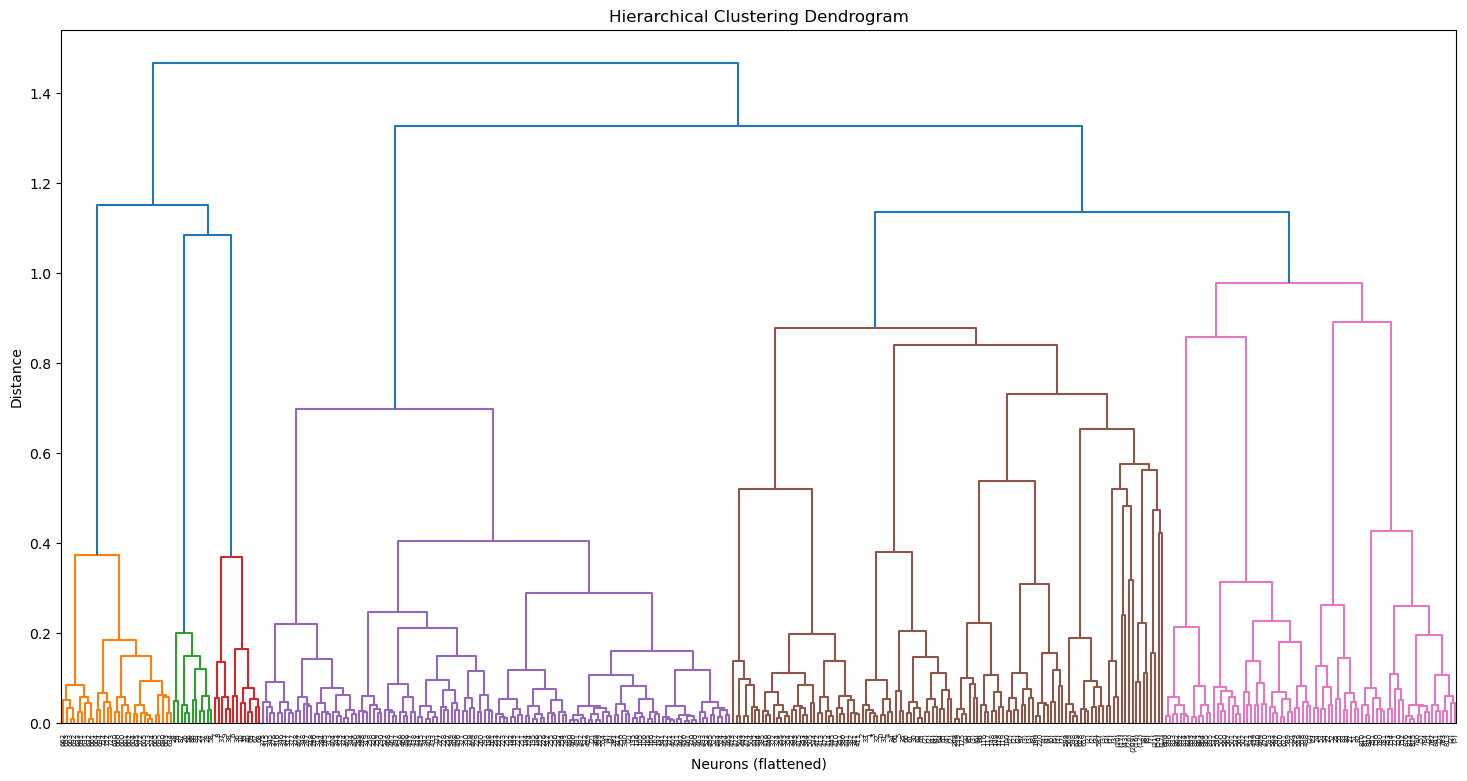

In [35]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# 1) Compute the linkage matrix (Ward's method, Euclidean distance)
linkage_matrix = linkage(weights_2d, method='ward', metric='euclidean')

# 2) Plot the dendrogram
plt.figure(figsize=(18, 9))
dendrogram(
    linkage_matrix,
    truncate_mode='level',  # or 'lastp'
    p=10                    # show only the last 10 merges
)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Neurons (flattened)")
plt.ylabel("Distance")
plt.show()


#### Flattened Weights + DataFrame

In [36]:
nodes_preferences = weights_2d

In [37]:
df_nodes_preferences = pd.DataFrame(nodes_preferences, columns=df_preferences.columns)
df_nodes_preferences['label'] = nodeclus_labels_preferences
df_nodes_preferences

CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  CUI_Chicken Dishes  \
0        0.012000   0.000598       0.000113  0.001485            0.001331   
1        0.009508   0.000274       0.000131  0.001743            0.002685   
2        0.009286   0.000719       0.000108  0.001406            0.003299   
3        0.010774   0.004975       0.000103  0.001088            0.002705   
4        0.010420   0.028426       0.000237  0.001076            0.002865   
..            ...        ...            ...       ...                 ...   
895      0.040933   0.008065       0.000061  0.000108            0.010670   
896      0.047664   0.012570       0.000307  0.000195            0.002929   
897      0.046555   0.009106       0.000992  0.000283            0.000664   
898      0.033245   0.004478       0.001506  0.000232            0.000123   
899      0.018383   0.003254       0.001061  0.000096            0.000164   

     CUI_Chinese  CUI_Desserts  CUI_Healthy  CUI_Indian  CUI_Italian  \
0       0.000010      0.000038     0.000002    0.151550     0.032870   
1       0.000009      0.000047     0.000002    0.195659     0.028172   
2       0.000012      0.000039     0.000007    0.225302     0.013388   
3       0.000045      0.000030     0.000038    0.205892     0.005968   
4       0.000171      0.000059     0.000399    0.165449     0.005940   
..           ...           ...          ...         ...          ...   
895     0.000017      0.001396     0.000186    0.006771     0.016135   
896     0.000027      0.000384     0.000288    0.011186     0.019932   
897     0.000067      0.000087     0.000369    0.014128     0.019350   
898     0.000104      0.000012     0.000255    0.008212     0.015233   
899     0.000110      0.000001     0.000087    0.002041     0.013986   

     CUI_Japanese  CUI_Noodle Dishes  CUI_OTHER  CUI_Street Food / Snacks  \
0        0.000259       8.624962e-13   0.004166                  0.001784   
1        0.000210       2.279762e-13   0.002370                  0.004678   
2        0.000083       8.450275e-14   0.006335                  0.006199   
3        0.000025       6.337643e-14   0.009564                  0.004067   
4        0.000067       1.405484e-13   0.006359                  0.002029   
..            ...                ...        ...                       ...   
895      0.010202       4.526393e-04   0.034333                  0.000003   
896      0.010822       1.459906e-04   0.025262                  0.000004   
897      0.009126       1.035522e-04   0.018058                  0.000028   
898      0.005429       2.320194e-04   0.008688                  0.000135   
899      0.002313       7.522199e-04   0.002054                  0.000281   

     CUI_Thai  label  
0    0.009216      0  
1    0.001487      0  
2    0.000495      0  
3    0.000451      0  
4    0.000358      0  
..        ...    ...  
895  0.222289      0  
896  0.168296      0  
897  0.122915      0  
898  0.077474      0  
899  0.047683      0  

[900 rows x 16 columns]

#### Hierarchical Labels for 8 Clusters and BMU Indices per Data Row

In [38]:
n_clusters = 8
hier_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')  # shape (M*N,)

# Get the BMU for each row in your data
bmu_index_preferences = [som.winner(sample) for sample in df_preferences_scaled]
bmu_index_preferences

[(3, 2),
 (16, 9),
 (19, 12),
 (5, 2),
 (5, 14),
 (0, 16),
 (21, 11),
 (19, 2),
 (27, 17),
 (0, 16),
 (8, 23),
 (4, 19),
 (0, 16),
 (0, 17),
 (6, 1),
 (14, 0),
 (19, 12),
 (10, 27),
 (20, 6),
 (7, 1),
 (14, 6),
 (3, 26),
 (21, 13),
 (29, 18),
 (28, 10),
 (20, 12),
 (6, 1),
 (2, 3),
 (29, 16),
 (10, 26),
 (7, 27),
 (14, 0),
 (6, 27),
 (27, 8),
 (2, 17),
 (22, 29),
 (26, 15),
 (9, 9),
 (19, 2),
 (28, 1),
 (10, 23),
 (20, 12),
 (10, 26),
 (2, 18),
 (27, 15),
 (2, 18),
 (11, 13),
 (29, 7),
 (6, 17),
 (16, 6),
 (11, 12),
 (13, 7),
 (28, 17),
 (10, 24),
 (6, 5),
 (7, 29),
 (16, 9),
 (19, 3),
 (24, 15),
 (4, 26),
 (9, 5),
 (27, 15),
 (25, 12),
 (29, 16),
 (20, 11),
 (24, 29),
 (25, 13),
 (25, 29),
 (16, 9),
 (15, 10),
 (0, 15),
 (28, 13),
 (25, 28),
 (0, 16),
 (11, 24),
 (25, 29),
 (10, 26),
 (10, 1),
 (29, 12),
 (2, 18),
 (14, 10),
 (16, 3),
 (8, 15),
 (8, 25),
 (9, 1),
 (25, 29),
 (29, 13),
 (5, 25),
 (17, 4),
 (11, 24),
 (16, 10),
 (0, 14),
 (16, 3),
 (10, 24),
 (29, 13),
 (10, 26),
 (25, 

#### Reshape Hierarchical Labels into a 2D Map and Final Labels per Data Row


In [39]:
# Reshape to a 2D label array
hier_map = hier_labels.reshape(M, N)  # same concept as your old 'hierarchical_matrix_preferences'

# Retrieve the hierarchical cluster label for each data row
som_final_labels_preferences = [hier_map[i, j] for (i, j) in bmu_index_preferences]

print(som_final_labels_preferences[:20])  # Just to see the first 20 labels

[5, 4, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


#### Combine with Original df_preferences

In [40]:
df_final_preferences = pd.concat([
    df_preferences,
    pd.Series(som_final_labels_preferences, name='label', index=df_preferences.index)
], axis=1)

df_final_preferences

CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  CUI_Chicken Dishes  \
0              0.00       0.00           0.00       0.0                 0.0   
1             12.82       6.39           0.00       0.0                 0.0   
2              9.20       0.00           0.00       0.0                 0.0   
3              0.00      13.70           0.00       0.0                 0.0   
4             14.57      40.87           0.00       0.0                 0.0   
...             ...        ...            ...       ...                 ...   
31883          0.00       0.00          18.04       0.0                 0.0   
31884         18.04       0.00           0.00       0.0                 0.0   
31885          0.00       0.00           0.00       0.0                 0.0   
31886          0.00      12.03           0.00       0.0                 0.0   
31887          0.00       0.00           0.00       0.0                 0.0   

       CUI_Chinese  CUI_Desserts  CUI_Healthy  CUI_Indian  CUI_Italian  \
0              0.0          0.00          0.0       28.88         0.00   
1              0.0          0.00          0.0        0.00         0.00   
2              0.0          0.00          0.0        0.00         0.00   
3              0.0          0.00          0.0       17.86         0.00   
4              0.0          0.00          0.0        0.00         0.00   
...            ...           ...          ...         ...          ...   
31883          0.0          0.00          0.0        0.00         0.00   
31884          0.0          0.00          0.0        0.00         0.00   
31885          0.0         17.79          0.0        0.00         0.00   
31886          0.0          0.00          0.0        0.00         0.00   
31887          0.0          0.00          0.0        0.00         7.91   

       CUI_Japanese  CUI_Noodle Dishes  CUI_OTHER  CUI_Street Food / Snacks  \
0               0.0                0.0        0.0                       0.0   
1               0.0                0.0        0.0                       0.0   
2               0.0                0.0        0.0                       0.0   
3               0.0                0.0        0.0                       0.0   
4               0.0                0.0        0.0                       0.0   
...             ...                ...        ...                       ...   
31883           0.0                0.0        0.0                       0.0   
31884           0.0                0.0        0.0                       0.0   
31885           0.0                0.0        0.0                       0.0   
31886           0.0                0.0        0.0                       0.0   
31887           0.0                0.0        0.0                       0.0   

       CUI_Thai  label  
0           0.0      5  
1           0.0      4  
2           0.0      5  
3           0.0      5  
4           0.0      5  
...         ...    ...  
31883       0.0      5  
31884       0.0      4  
31885       0.0      5  
31886       0.0      5  
31887       0.0      5  

[31736 rows x 16 columns]

#### Group and Aggregate

In [41]:
df_final_preferences[df_preferences.columns.tolist()+['label']].groupby('label').mean()

CUI_American   CUI_Asian  CUI_Beverages   CUI_Cafe  CUI_Chicken Dishes  \
label                                                                           
1          4.104323   17.115746      43.675925   0.273909            0.434945   
2          9.094783   36.832217       5.532391   0.000000            0.000000   
3         13.900256  211.469915       6.810513   0.431197            0.000000   
4         27.292165    9.640323       0.680127   0.860756            0.222474   
5          1.781590    8.958281       1.409499   0.405264            0.866220   
6          7.773662    6.996592       1.411001   3.079865            1.598655   
7          8.009124   10.899927       0.116350  69.010876            0.496204   
8          3.037542    2.783517       0.008008   0.528008            0.027444   

       CUI_Chinese  CUI_Desserts  CUI_Healthy  CUI_Indian  CUI_Italian  \
label                                                                    
1         1.700718      1.491878     0.912265    0.240442     0.130981   
2         2.499348      3.578652     1.458391    0.000000     0.183261   
3         4.757692      4.262222     2.364444    0.785726     0.418291   
4         0.622561      0.340676     0.558011    0.871302     4.019154   
5         1.485900      0.944848     0.959024    1.762227     1.751577   
6         2.421211      0.451704     2.045381    3.866891     9.557668   
7         1.600657      0.292847     6.167226    3.100365    13.207883   
8         0.525678      0.008220     0.348658    0.638390    50.539972   

       CUI_Japanese  CUI_Noodle Dishes  CUI_OTHER  CUI_Street Food / Snacks  \
label                                                                         
1          2.639641           0.250028   1.155815                  5.029489   
2          8.303261           0.000000   0.296696                128.849304   
3         10.082821           0.019060   1.308034                 16.499145   
4          2.576634           0.059241   2.127312                  1.808005   
5          2.911374           0.836225   2.344461                  3.206804   
6          5.763692           0.894051  34.451196                  0.413812   
7         10.157372           0.077299  16.774891                  0.615255   
8          2.057203           0.026540   2.198644                  0.603164   

        CUI_Thai  
label             
1       0.194848  
2       0.000000  
3       0.239145  
4       0.261521  
5       0.504497  
6      17.798804  
7       2.945547  
8       0.544449

<a class="anchor" id="mean">

## 3.4. Mean Shift Clustering
</a>

In [42]:
# The following bandwidth can be automatically detected using 
# # (we need to set quantile though)
# Based on distance to nearest neighbors for all observations

bandwidth = estimate_bandwidth(df_preferences, quantile=0.06, random_state=1, n_jobs=-1)
bandwidth
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_preferences)
ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

KeyboardInterrupt: 

In [43]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_preferences)
ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 891


In [44]:
# Dúvida --> too many estimated clusters

The number of estimated clusters in mean-shift clustering can be influenced by several factors:

Bandwidth Parameter: The bandwidth parameter is crucial in mean-shift clustering. It determines the radius of the region used to compute the mean shift. If the bandwidth is too small, the algorithm may identify many small clusters, leading to a high number of estimated clusters. Conversely, a larger bandwidth may result in fewer clusters.

Data Distribution: The inherent distribution of your data can also affect the number of clusters. If your data has many dense regions, the mean-shift algorithm will identify each of these regions as a separate cluster.

Feature Selection: The features used for clustering (metric_features in this case) play a significant role. If the selected features have high variability or many distinct patterns, the algorithm may detect more clusters.

Noise and Outliers: The presence of noise and outliers in your data can lead to the identification of additional clusters. Mean-shift clustering is sensitive to such anomalies, which can increase the number of clusters.

To reduce the number of estimated clusters, you can try the following:

Adjust the Bandwidth: Increase the bandwidth parameter to merge nearby clusters.
Data Preprocessing: Normalize or standardize your data to reduce variability.
Feature Selection: Carefully select or reduce the number of features used for clustering.
Outlier Removal: Remove or handle outliers in your data before clustering.
You can experiment with these adjustments to find a more suitable number of clusters for your specific dataset.

In [45]:
df_preferences_labels = pd.concat([df_preferences, pd.Series(ms_labels, index=df.index, name="ms_labels")], axis=1)
df_preferences_labels.head()

NameError: name 'df' is not defined

<a class="anchor" id="dbscan">

## 3.5. DBSCAN
</a>

In [ ]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df_preferences)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

In [ ]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df_preferences[metric_features])
distances, _ = neigh.kneighbors(df_preferences)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [ ]:
# Concatenating the labels to df
df_preferences_labels = pd.concat([df_preferences, pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
df_preferences_labels.head()

In [ ]:
# Detecting noise (potential outliers)
df_preferences_labels.loc[df_preferences_labels['dbscan_labels'] == -1]

In [ ]:
# Computing the R^2 of the cluster solution
df_nonoise = df_preferences_labels.loc[df_preferences_labels['dbscan_labels'] != -1]
sst = get_ss(df_preferences[metric_features])  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

<a class="anchor" id="hierarchical">

## 3.6. GMM (Gaussian Mixture Model)
</a>


In [ ]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_preferences)
labels_proba = gmm.predict_proba(df_preferences)

Estimated Parameters:

In [ ]:
# The estimated component weights
gmm.weights_

In [ ]:
# The estimated mean vectors of the Components
print(gmm.means_.shape)
gmm.means_

In [ ]:
# The estimated covariance matrices of the Components
gmm.covariances_.shape

### Defining n_components:

In [ ]:
# This may take a while to run
# 
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_preferences)
          for n in n_components]

bic_values = [m.bic(df_preferences) for m in models]
aic_values = [m.aic(df_preferences) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [ ]:
# Concatenating the labels to df
df_preferences_labels = pd.concat([df_preferences, pd.Series(gmm_labels, index=df.index, name="gmm_labels")], axis=1)
df_preferences_labels.head()

In [ ]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_preferences)

<a class="anchor" id="density">

## 3.7. Density Based Clustering
</a>

In [ ]:
# ? concat things from SOM onwards into df_contact? ( keep a df that has everything )
# ? metric features = numeric_columns right? not numeric_columns_complet (might generate confusion)

In [ ]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth

In [ ]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable